In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys

import random

import numpy as np

from io import BytesIO
from PIL import Image

import torch
from torchvision.transforms.functional import to_pil_image

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.minio.cmd import connect_to_minio_client
from worker.image_generation.scripts.stable_diffusion_base_script import StableDiffusionBaseScript

INFO: Created a temporary directory at /tmp/tmppucem4vr
INFO: Writing /tmp/tmppucem4vr/_remote_module_non_scriptable.py


In [3]:
from stable_diffusion import StableDiffusion, CLIPTextEmbedder

In [4]:
model_path = '../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_tokenizer'
transformer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_model'

In [5]:
txt2img = StableDiffusionBaseScript(
    sampler_name="ddim",
    n_steps=20,
    force_cpu=False,
    cuda_device='cuda',
)

In [6]:
txt2img.initialize_latent_diffusion(
    autoencoder=None, 
    clip_text_embedder=None, 
    unet_model=None,
    path=model_path, 
    force_submodels_init=True)

  encoder initialization...[DONE]	975.28ms                                        
  decoder initialization...[DONE]	382.84ms                                        
Autoencoder initialization...[DONE]	1,362.03ms                                    
U-Net initialization...[DONE]	6,494.13ms                                          
Latent Diffusion model initialization...[DONE]	7.61ms                             
stable diffusion checkpoint loading, from ../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors...[DONE]	189.04ms
	missing keys 2: ['beta', 'alpha_bar']
	extra keys 14: ['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
model state loading...[DONE]	1,

In [7]:
clip_text_embedder = CLIPTextEmbedder(device='cuda')

In [8]:
clip_text_embedder.load_submodels(
    tokenizer_path=tokenizer_path,
    transformer_path=transformer_path
);

Loading tokenizer and transformer...[DONE]	1,039.32ms                             


In [9]:
def get_image_data(images: torch.Tensor):
    # Map images to `[0, 1]` space and clip
    images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
    # Transpose to `[batch_size, height, width, channels]` and convert to numpy
    images = images.cpu()
    images = images.permute(0, 2, 3, 1)
    images = images.detach().float().numpy()

    return Image.fromarray((255. * images[0]).astype(np.uint8))

# generate

In [10]:
positive_prompt = '2D environmental side scrolling,  at the city, in the style of h Hirohi- kiyohara and Akiyiyuyuki, pixel gloss style;'
negative_prompt = ''

seed = random.randint(0, 2 ** 24 - 1)
cfg_strength = 12
image_width = 512
image_height = 512

In [11]:
with torch.no_grad():
    
    embedded_prompts = clip_text_embedder(positive_prompt)
    negative_embedded_prompts = clip_text_embedder(negative_prompt)
    
    latent = txt2img.generate_images_latent_from_embeddings(
        batch_size=1,
        embedded_prompt=embedded_prompts,
        null_prompt=negative_embedded_prompts,
        uncond_scale=cfg_strength,
        seed=seed,
        w=image_width,
        h=image_height
    )
    
    images = txt2img.get_image_from_latent(latent)

Sample...[DONE]	3,631.34ms                                                        


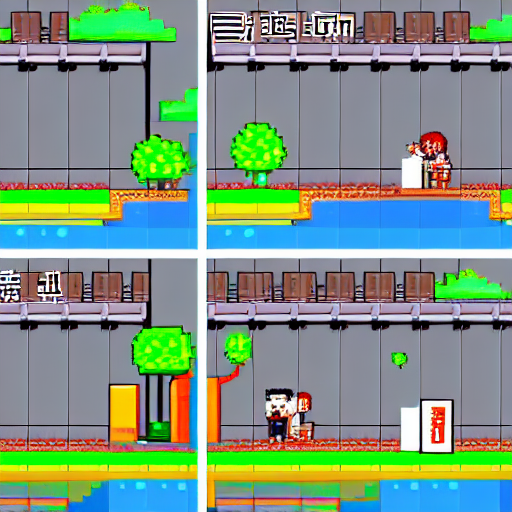

In [12]:
get_image_data(images)

# replicate

In [13]:
from minio import Minio
import requests
import msgpack

In [14]:
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

In [15]:
bucket_name = 'datasets'
object_name = 'environmental/0001/000000_data.msgpack'

In [16]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [17]:
data = client.get_object(bucket_name, object_name).data
decoded_data = msgpack.unpackb(data)
decoded_data

{'job_uuid': 'e9fcd18d-71cd-4320-a2f5-32e02c872cc5',
 'creation_time': '2023-10-04 08:41:30',
 'dataset': 'environmental',
 'file_path': 'environmental/0001/000000_data.msgpack',
 'file_hash': '837a665df2e743f67805b74d8e504fd382d82490a8e9a09e8aad17d2020f1539',
 'positive_prompt': 'environmental, pixel art, concept art, side scrolling, video game, neo city, (1 girl), white box, puffy lips, cinematic lighting, colorful, steampunk, partially submerged, original, 1girl, night, ribbon choker, see through top, black tissues, a masterpiece, high heel, hand on own crotch',
 'negative_prompt': 'bad hands, jewelry, extra fingers, (signature:1.2), flat shading, muscular, (((disfigured))), poorly drawn mouth, low quality lowres extra breasts, badv4, unoriginal, fused fingers, bad-image-v2-27000, malformed limbs, (lipstick makeup)',
 'cfg_strength': 12,
 'seed': 16577212,
 'image_width': 512,
 'image_height': 512,
 'sampler': 'ddim',
 'sampler_steps': 20}

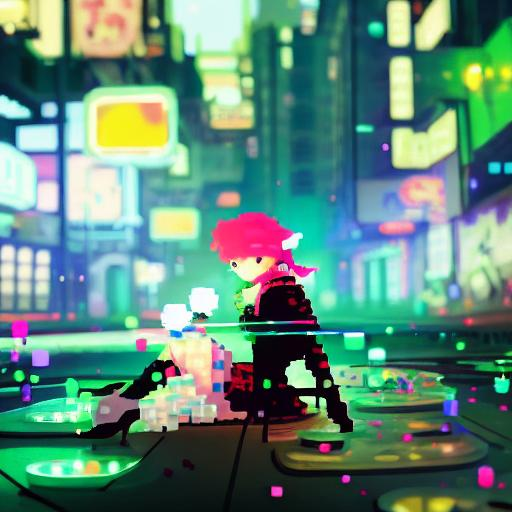

In [18]:
data = client.get_object(bucket_name, object_name.replace('_data.msgpack', '.jpg')).data
Image.open(BytesIO(data))

In [19]:
positive_prompt = decoded_data['positive_prompt']
negative_prompt = decoded_data['negative_prompt']
seed = decoded_data['seed']
cfg_strength = decoded_data['cfg_strength']
image_width = decoded_data['image_width']
image_height = decoded_data['image_height']

In [20]:
with torch.no_grad():
    
    embedded_prompts = clip_text_embedder(positive_prompt)
    negative_embedded_prompts = clip_text_embedder(negative_prompt)
    
    latent = txt2img.generate_images_latent_from_embeddings(
        batch_size=1,
        embedded_prompt=embedded_prompts,
        null_prompt=negative_embedded_prompts,
        uncond_scale=cfg_strength,
        seed=seed,
        w=image_width,
        h=image_height
    )
    
    images = txt2img.get_image_from_latent(latent)

Sample...[DONE]	3,271.11ms                                                        


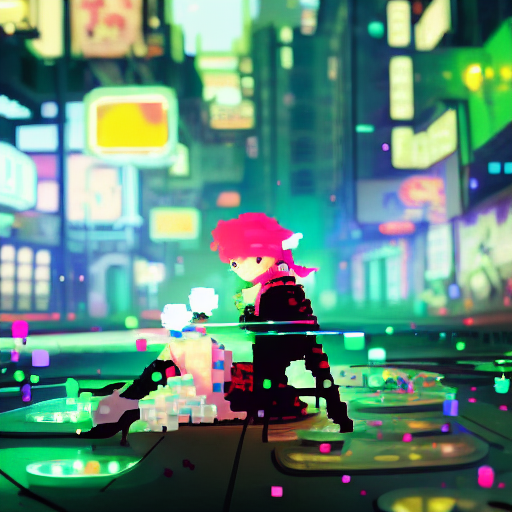

In [21]:
get_image_data(images)